# Import and Install Dependencies


In [18]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Keypoints using MP Holistic

In [19]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [20]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results


In [21]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) #draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) #draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) #draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) #draw right hand connections

In [22]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
#set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #read feed 
        ret,frame=cap.read()

        #Make Detections
        image,results=mediapipe_detection(frame,holistic)
        
        #Draw landmarks
        draw_styled_landmarks(image,results)

        #show the screen
        cv2.imshow('OpenCV Feed', image)

        #break and escape from window
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [7]:
len(results.left_hand_landmarks.landmark)

21

In [8]:
results

mediapipe.python.solution_base.SolutionOutputs

In [9]:
draw_landmarks(frame, results)

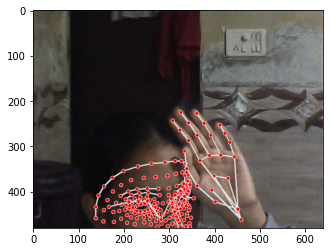

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


# Extract Keypoint Values

In [11]:
len(results.left_hand_landmarks.landmark)

21

In [12]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [23]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [14]:
result_test = extract_keypoints(results)

In [15]:
result_test

array([ 0.44165939,  0.96091521, -1.9643352 , ...,  0.        ,
        0.        ,  0.        ])

In [16]:
extract_keypoints(results).shape

(1662,)

# Setup Folders for Collection

In [24]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['A', 'B', 'C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'
                    ])

# Thirty videos worth of data
no_sequences = 150

# Videos are going to be 30 frames in length
sequence_length = 30

In [25]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collect Keypoint Values for Training and Testing

In [26]:
def collect_keypoints(actions):
    cap = cv2.VideoCapture(0)
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        # NEW LOOP
        # Loop through actions
        for action in actions:
            # Loop through sequences aka videos
            for sequence in range(no_sequences):
                # Loop through video length aka sequence length
                for frame_num in range(sequence_length):
                    if sequence>=0 and sequence<60:
                        # Read feed
                        ret, frame = cap.read()

                        # Make detections
                        image, results = mediapipe_detection(frame, holistic)
#                         print(results)

                        # Draw landmarks
                        draw_styled_landmarks(image, results)

                        # NEW Apply wait logic
                        if frame_num == 0: 
                            cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                            cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                            # Show to screen
                            cv2.imshow('OpenCV Feed', image)
                            cv2.waitKey(2000)
                        else: 
                            cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                            # Show to screen
                            cv2.imshow('OpenCV Feed', image)

                        # NEW Export keypoints
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                        np.save(npy_path, keypoints)

                        # Break gracefully
                        if cv2.waitKey(10) & 0xFF == ord('q'):
                            break

        cap.release()
        cv2.destroyAllWindows()

In [20]:
# set1= np.array(['A'])
# collect_keypoints(set1)

In [21]:
# set2= np.array(['B'])
# collect_keypoints(set2)

In [22]:
# set3= np.array(['C'])
# collect_keypoints(set3)

In [23]:
# set4= np.array(['D'])
# collect_keypoints(set4)

In [24]:
# set5= np.array(['E'])
# collect_keypoints(set5)

In [25]:
# set6= np.array(['F'])
# collect_keypoints(set6)

In [26]:
# set7= np.array(['G'])
# collect_keypoints(set7)

In [27]:
# set8= np.array(['H'])
# collect_keypoints(set8)

In [28]:
# set9= np.array(['I'])
# collect_keypoints(set9)

In [29]:
# set10= np.array(['J'])
# collect_keypoints(set10)

In [30]:
# set11= np.array(['K'])
# collect_keypoints(set11)

In [31]:
# set12= np.array(['L'])
# collect_keypoints(set12)

In [32]:
# set13= np.array(['M'])
# collect_keypoints(set13) 

In [33]:
# set14= np.array(['N'])
# collect_keypoints(set14)

In [34]:
# set15= np.array(['O'])
# collect_keypoints(set15)

In [35]:
# set16= np.array(['P'])
# collect_keypoints(set16)

In [36]:
# set17= np.array(['Q'])
# collect_keypoints(set17)

In [37]:
# set18= np.array(['R'])
# collect_keypoints(set18)

In [38]:
# set19= np.array(['S'])
# collect_keypoints(set19)

In [39]:
# set20= np.array(['T'])
# collect_keypoints(set20) 

In [40]:
# set21= np.array(['U'])
# collect_keypoints(set21)

In [41]:
# set22= np.array(['V'])
# collect_keypoints(set22)

In [42]:
# set23= np.array(['W'])
# collect_keypoints(set23)

In [43]:
# set24= np.array(['X'])
# collect_keypoints(set24)

In [44]:
# set25= np.array(['Y'])
# collect_keypoints(set25)

In [45]:
# set26= np.array(['Z'])
# collect_keypoints(set26)

In [46]:
# set1= np.array(['A'])
# collect_keypoints(set1)

# set2= np.array(['B'])
# collect_keypoints(set2)

# set3= np.array(['C'])
# collect_keypoints(set3) 

# set4= np.array(['D'])
# collect_keypoints(set4)

# set5= np.array(['E'])
# collect_keypoints(set5)

# set6= np.array(['F'])
# collect_keypoints(set6)

# set7= np.array(['G'])
# collect_keypoints(set7)

# set8= np.array(['H'])
# collect_keypoints(set8)

# set9= np.array(['I'])
# collect_keypoints(set9)

# set10= np.array(['J'])
# collect_keypoints(set10)

# set11= np.array(['K'])
# collect_keypoints(set11)

# set12= np.array(['L'])
# collect_keypoints(set12)

# set13= np.array(['M'])
# collect_keypoints(set13)

# set14= np.array(['N'])
# collect_keypoints(set14)

# set15= np.array(['O'])
# collect_keypoints(set15)

# set16= np.array(['P'])
# collect_keypoints(set16)

# set17= np.array(['Q'])
# collect_keypoints(set17)

# set18= np.array(['R'])
# collect_keypoints(set18)

# set19= np.array(['S'])
# collect_keypoints(set19)

# set20= np.array(['T'])
# collect_keypoints(set20)

# set21= np.array(['U'])
# collect_keypoints(set21)

# set22= np.array(['V'])
# collect_keypoints(set22)

# set23= np.array(['W'])
# collect_keypoints(set23)

# set24= np.array(['X'])
# collect_keypoints(set24)

# set25= np.array(['Y'])
# collect_keypoints(set25)

# set26= np.array(['Z'])
# collect_keypoints(set26)

# set27= np.array(['You'])
# collect_keypoints(set27)

# set28= np.array(['Welcome'])
# collect_keypoints(set28)

# set29= np.array(['Thankyou'])
# collect_keypoints(set29)

# set30= np.array(['Sign'])
# collect_keypoints(set30)

# set31= np.array(['Name-is'])
# collect_keypoints(set31)

# set32= np.array(['Namaste'])
# collect_keypoints(set32)

# set33= np.array(['Language'])
# collect_keypoints(set33)

# set34= np.array(['Interpreter'])
# collect_keypoints(set34)

# set35= np.array(['Indian'])
# collect_keypoints(set35)

# set36= np.array(['Hello'])
# collect_keypoints(set36)

# set37= np.array(['Bye'])
# collect_keypoints(set37)

# set38= np.array(['My'])
# collect_keypoints(set38)

# set39= np.array(['Yes'])
# collect_keypoints(set39)

# set40= np.array(['No'])
# collect_keypoints(set40)

# Preprocess Data and Create Labels and Features

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [48]:
label_map = {label:num for num, label in enumerate(actions)}

In [49]:
label_map

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [50]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [51]:
np.array(sequences).shape

(3900, 30, 1662)

In [52]:
np.array(labels).shape

(3900,)

In [53]:
X = np.array(sequences)

In [54]:
X.shape

(3900, 30, 1662)

In [55]:
y = to_categorical(labels).astype(int)

In [56]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [57]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [66]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.5)

In [67]:
y_test1.shape


(1950, 26)

# Build and Train LSTM Neural Network

In [27]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [69]:
log_dir = os.path.join('Logs2')
tb_callback = TensorBoard(log_dir=log_dir)

In [70]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [71]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [72]:
# model.fit(X_train, y_train, epochs=50, callbacks=[tb_callback])

In [73]:
model.fit(X_train1, y_train1, epochs=50, callbacks=[tb_callback])

Epoch 1/50
61/61 [==============================] - 6s 61ms/step - loss: 3.2696 - categorical_accuracy: 0.0297
Epoch 2/50
61/61 [==============================] - 4s 60ms/step - loss: 3.2581 - categorical_accuracy: 0.0328
Epoch 3/50
61/61 [==============================] - 4s 60ms/step - loss: 3.2538 - categorical_accuracy: 0.0503
Epoch 4/50
61/61 [==============================] - 4s 60ms/step - loss: 3.2480 - categorical_accuracy: 0.0544
Epoch 5/50
61/61 [==============================] - 4s 60ms/step - loss: 3.2478 - categorical_accuracy: 0.0569
Epoch 6/50
61/61 [==============================] - 4s 61ms/step - loss: 3.3371 - categorical_accuracy: 0.0579
Epoch 7/50
61/61 [==============================] - 4s 62ms/step - loss: 2.8617 - categorical_accuracy: 0.0728
Epoch 8/50
61/61 [==============================] - 4s 63ms/step - loss: 2.7541 - categorical_accuracy: 0.0826
Epoch 9/50
61/61 [==============================] - 4s 68ms/step - loss: 2.7317 - categorical_accuracy: 0.0979
E

In [74]:
model.save('chal.h5')

In [75]:
newmodel=tensorflow.keras.models.load_model('chal.h5')

In [76]:
newmodel.fit(X_train1, y_train1, epochs=50, callbacks=[tb_callback])

Epoch 1/50
61/61 [==============================] - 5s 59ms/step - loss: 1.6050 - categorical_accuracy: 0.3877
Epoch 2/50
61/61 [==============================] - 4s 60ms/step - loss: 1.5258 - categorical_accuracy: 0.4313
Epoch 3/50
61/61 [==============================] - 4s 61ms/step - loss: 1.5695 - categorical_accuracy: 0.4262
Epoch 4/50
61/61 [==============================] - 4s 58ms/step - loss: 1.5077 - categorical_accuracy: 0.4451
Epoch 5/50
61/61 [==============================] - 4s 59ms/step - loss: 1.4991 - categorical_accuracy: 0.4410
Epoch 6/50
61/61 [==============================] - 4s 59ms/step - loss: 1.5175 - categorical_accuracy: 0.4359
Epoch 7/50
61/61 [==============================] - 4s 57ms/step - loss: 1.4064 - categorical_accuracy: 0.4631
Epoch 8/50
61/61 [==============================] - 4s 58ms/step - loss: 1.4026 - categorical_accuracy: 0.4749
Epoch 9/50
61/61 [==============================] - 4s 59ms/step - loss: 1.4728 - categorical_accuracy: 0.4554
E

In [77]:
newmodel.save('chal1.h5')

In [78]:
newmodel1=tensorflow.keras.models.load_model('chal1.h5')

In [79]:
newmodel1.fit(X_train1, y_train1, epochs=50, callbacks=[tb_callback])

Epoch 1/50
61/61 [==============================] - 5s 64ms/step - loss: 1.2121 - categorical_accuracy: 0.5626
Epoch 2/50
61/61 [==============================] - 4s 62ms/step - loss: 1.1470 - categorical_accuracy: 0.5682
Epoch 3/50
61/61 [==============================] - 4s 61ms/step - loss: 1.1078 - categorical_accuracy: 0.5862
Epoch 4/50
61/61 [==============================] - 4s 62ms/step - loss: 1.1321 - categorical_accuracy: 0.5831
Epoch 5/50
61/61 [==============================] - 4s 62ms/step - loss: 1.0862 - categorical_accuracy: 0.5933
Epoch 6/50
61/61 [==============================] - 4s 61ms/step - loss: 1.0340 - categorical_accuracy: 0.5985
Epoch 7/50
61/61 [==============================] - 4s 61ms/step - loss: 1.0209 - categorical_accuracy: 0.6128
Epoch 8/50
61/61 [==============================] - 4s 61ms/step - loss: 1.0102 - categorical_accuracy: 0.6179
Epoch 9/50
61/61 [==============================] - 4s 60ms/step - loss: 0.9476 - categorical_accuracy: 0.6538
E

In [81]:
newmodel1.save('chal2.h5')

In [114]:
newmodel1.fit(X_train1, y_train1, epochs=50, callbacks=[tb_callback])

Epoch 1/50
61/61 [==============================] - 5s 60ms/step - loss: 1.0111 - categorical_accuracy: 0.6544
Epoch 2/50
61/61 [==============================] - 4s 59ms/step - loss: 0.7748 - categorical_accuracy: 0.7092
Epoch 3/50
61/61 [==============================] - 4s 59ms/step - loss: 0.6961 - categorical_accuracy: 0.7441
Epoch 4/50
61/61 [==============================] - 4s 59ms/step - loss: 0.5840 - categorical_accuracy: 0.7774
Epoch 5/50
61/61 [==============================] - 4s 60ms/step - loss: 0.6343 - categorical_accuracy: 0.7621
Epoch 6/50
61/61 [==============================] - 4s 59ms/step - loss: 0.6631 - categorical_accuracy: 0.7538
Epoch 7/50
61/61 [==============================] - 4s 60ms/step - loss: 0.5801 - categorical_accuracy: 0.7810
Epoch 8/50
61/61 [==============================] - 4s 59ms/step - loss: 0.6654 - categorical_accuracy: 0.7518
Epoch 9/50
61/61 [==============================] - 4s 60ms/step - loss: 0.5484 - categorical_accuracy: 0.7892
E

KeyboardInterrupt: 

In [115]:
newmodel1.save('bahara.h5')

In [128]:
newmodel1.fit(X_train1, y_train1, epochs=50, callbacks=[tb_callback])

Epoch 1/50
61/61 [==============================] - 4s 61ms/step - loss: 0.4079 - categorical_accuracy: 0.8523
Epoch 2/50
61/61 [==============================] - 4s 59ms/step - loss: 0.6523 - categorical_accuracy: 0.7610
Epoch 3/50
61/61 [==============================] - 4s 59ms/step - loss: 0.6297 - categorical_accuracy: 0.7564
Epoch 4/50
61/61 [==============================] - 4s 60ms/step - loss: 0.6895 - categorical_accuracy: 0.7369
Epoch 5/50
61/61 [==============================] - 4s 60ms/step - loss: 0.6466 - categorical_accuracy: 0.7533
Epoch 6/50
61/61 [==============================] - 4s 59ms/step - loss: 0.6054 - categorical_accuracy: 0.7713
Epoch 7/50
61/61 [==============================] - 4s 59ms/step - loss: 0.4970 - categorical_accuracy: 0.8062
Epoch 8/50
61/61 [==============================] - 4s 59ms/step - loss: 0.5645 - categorical_accuracy: 0.7990
Epoch 9/50
61/61 [==============================] - 4s 59ms/step - loss: 0.7331 - categorical_accuracy: 0.7297
E

In [129]:
newmodel1.save('hawa.h5')

In [130]:
hawa=tensorflow.keras.models.load_model('hawa.h5')

In [137]:
hawa.fit(X_train1, y_train1, epochs=50, callbacks=[tb_callback])

Epoch 1/50
61/61 [==============================] - 5s 59ms/step - loss: 0.9754 - categorical_accuracy: 0.7277
Epoch 2/50
61/61 [==============================] - 4s 58ms/step - loss: 0.5052 - categorical_accuracy: 0.8287
Epoch 3/50
61/61 [==============================] - 4s 58ms/step - loss: 0.3343 - categorical_accuracy: 0.8856
Epoch 4/50
61/61 [==============================] - 4s 58ms/step - loss: 0.3898 - categorical_accuracy: 0.8641
Epoch 5/50
61/61 [==============================] - 4s 58ms/step - loss: 0.3540 - categorical_accuracy: 0.8815
Epoch 6/50
61/61 [==============================] - 4s 58ms/step - loss: 0.5731 - categorical_accuracy: 0.7974
Epoch 7/50
61/61 [==============================] - 4s 58ms/step - loss: 0.2887 - categorical_accuracy: 0.9000
Epoch 8/50
61/61 [==============================] - 4s 58ms/step - loss: 0.3074 - categorical_accuracy: 0.8897
Epoch 9/50
61/61 [==============================] - 4s 59ms/step - loss: 0.2998 - categorical_accuracy: 0.8938
E

KeyboardInterrupt: 

In [138]:
hawa.save('great.h5')

In [139]:
great=tensorflow.keras.models.load_model('great.h5')

In [144]:
great.fit(X_train1, y_train1, epochs=50, callbacks=[tb_callback])

Epoch 1/50
61/61 [==============================] - 5s 60ms/step - loss: 0.2721 - categorical_accuracy: 0.9005
Epoch 2/50
61/61 [==============================] - 4s 58ms/step - loss: 0.5101 - categorical_accuracy: 0.8113
Epoch 3/50
61/61 [==============================] - 4s 60ms/step - loss: 0.3058 - categorical_accuracy: 0.8938
Epoch 4/50
61/61 [==============================] - 4s 58ms/step - loss: 0.2834 - categorical_accuracy: 0.9005
Epoch 5/50
61/61 [==============================] - 4s 59ms/step - loss: 0.2323 - categorical_accuracy: 0.9179
Epoch 6/50
61/61 [==============================] - 4s 58ms/step - loss: 0.2594 - categorical_accuracy: 0.9072
Epoch 7/50
61/61 [==============================] - 4s 58ms/step - loss: 0.3090 - categorical_accuracy: 0.8846
Epoch 8/50
61/61 [==============================] - 4s 60ms/step - loss: 0.3624 - categorical_accuracy: 0.8631
Epoch 9/50
61/61 [==============================] - 4s 58ms/step - loss: 0.4094 - categorical_accuracy: 0.8677
E

KeyboardInterrupt: 

In [145]:
great.save('grate.h5')

In [146]:
grate=tensorflow.keras.models.load_model('grate.h5')

In [153]:
grate.fit(X_train1, y_train1, epochs=50, callbacks=[tb_callback])

Epoch 1/50
61/61 [==============================] - 5s 59ms/step - loss: 0.2491 - categorical_accuracy: 0.9205
Epoch 2/50
61/61 [==============================] - 4s 59ms/step - loss: 0.2799 - categorical_accuracy: 0.9031
Epoch 3/50
61/61 [==============================] - 4s 59ms/step - loss: 0.1875 - categorical_accuracy: 0.9359
Epoch 4/50
61/61 [==============================] - 4s 59ms/step - loss: 0.4648 - categorical_accuracy: 0.8349
Epoch 5/50
61/61 [==============================] - 4s 59ms/step - loss: 0.4989 - categorical_accuracy: 0.8185
Epoch 6/50
61/61 [==============================] - 4s 59ms/step - loss: 0.3013 - categorical_accuracy: 0.8836
Epoch 7/50
61/61 [==============================] - 4s 59ms/step - loss: 0.2168 - categorical_accuracy: 0.9267
Epoch 8/50
61/61 [==============================] - 4s 59ms/step - loss: 0.1480 - categorical_accuracy: 0.9467
Epoch 9/50
61/61 [==============================] - 4s 59ms/step - loss: 0.1357 - categorical_accuracy: 0.9574
E

KeyboardInterrupt: 

In [154]:
grate.save('kya.h5')

In [155]:
kya=tensorflow.keras.models.load_model('kya.h5')

In [159]:
kya.fit(X_train1, y_train1, epochs=50, callbacks=[tb_callback])

Epoch 1/50
61/61 [==============================] - 5s 61ms/step - loss: 0.1734 - categorical_accuracy: 0.9379
Epoch 2/50
61/61 [==============================] - 4s 61ms/step - loss: 0.3571 - categorical_accuracy: 0.8682
Epoch 3/50
61/61 [==============================] - 4s 61ms/step - loss: 0.1599 - categorical_accuracy: 0.9456
Epoch 4/50
61/61 [==============================] - 4s 61ms/step - loss: 0.1435 - categorical_accuracy: 0.9482
Epoch 5/50
61/61 [==============================] - 4s 61ms/step - loss: 0.1331 - categorical_accuracy: 0.9615
Epoch 6/50
61/61 [==============================] - 4s 61ms/step - loss: 0.1414 - categorical_accuracy: 0.9523
Epoch 7/50
61/61 [==============================] - 4s 61ms/step - loss: 0.2542 - categorical_accuracy: 0.9118
Epoch 8/50
61/61 [==============================] - 4s 61ms/step - loss: 1.0275 - categorical_accuracy: 0.7036
Epoch 9/50
61/61 [==============================] - 4s 61ms/step - loss: 0.2392 - categorical_accuracy: 0.9236
E

KeyboardInterrupt: 

In [160]:
kya.save('kaha.h5')

In [161]:
kaha=tensorflow.keras.models.load_model('kaha.h5')

In [158]:
kya.save('kyu.h5')

In [28]:
kyu=tensorflow.keras.models.load_model('kyu.h5')

In [133]:
hawa.save('hawayi.h5')

In [134]:
hawayi=tensorflow.keras.models.load_model('hawayi.h5')

In [116]:
bahar=tensorflow.keras.models.load_model('bahara.h5')

In [119]:
bahar.save('bhaari.h5')

In [125]:
bhaari=tensorflow.keras.models.load_model('bhaari.h5')

In [82]:
newmodel2=tensorflow.keras.models.load_model('chal2.h5')

In [96]:
newmodel3=tensorflow.keras.models.load_model('chal2.h5')

In [ ]:
newmodel3.fit(X_train1, y_train1, epochs=50, callbacks=[tb_callback])

In [109]:
new=tensorflow.keras.models.load_model('chalti.h5')

In [167]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = kyu.predict(X_test1)
ytrue = np.argmax(y_test1, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [169]:
multilabel_confusion_matrix(ytrue, yhat)


array([[[1847,   29],
        [  20,   54]],

       [[1842,   29],
        [  32,   47]],

       [[1843,   36],
        [  14,   57]],

       [[1851,   30],
        [  37,   32]],

       [[1852,   14],
        [  26,   58]],

       [[1843,   34],
        [  28,   45]],

       [[1841,   27],
        [  23,   59]],

       [[1859,   21],
        [  21,   49]],

       [[1839,   42],
        [  18,   51]],

       [[1859,   17],
        [  22,   52]],

       [[1846,   28],
        [  33,   43]],

       [[1865,   15],
        [  26,   44]],

       [[1846,   22],
        [  46,   36]],

       [[1848,   35],
        [  20,   47]],

       [[1863,   12],
        [  12,   63]],

       [[1830,   37],
        [  29,   54]],

       [[1851,   27],
        [  18,   54]],

       [[1870,   14],
        [  17,   49]],

       [[1835,   40],
        [  37,   38]],

       [[1834,   31],
        [  57,   28]],

       [[1854,   16],
        [  28,   52]],

       [[1875,    1],
        [   

In [168]:
accuracy_score(ytrue, yhat)*100

66.41025641025641

In [29]:
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = kyu.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
         #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1: 
                sentence = sentence[-1:]
                
            cv2.putText(image, ' '.join(sentence), (25,80), cv2.FONT_HERSHEY_SIMPLEX, 2, (112, 41, 99), 6, cv2.LINE_AA)
            cv2.putText(image,'Press q to Exit', (460,470), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (112, 41, 99), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
Y
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Y
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Q
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Y
<class 'mediapipe.python.solution_base.SolutionOutputs'>
H
<class 'mediapipe.python.solution_base.SolutionOutputs'>
M
<class 'mediapipe.python.solution_base.SolutionOutputs'>
M
<class 'mediapipe.python.solution_base.SolutionOutputs'>
T
<class 'mediapipe.python.solution_base.SolutionOutputs'>
S
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Y
<class 'mediapipe.python.solution_base.SolutionOutputs'>
T
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Y
<class 'mediapipe.python.solution_base.SolutionOutputs'>
S
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Y
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Y
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>
P
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
T
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Z
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Z
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
T
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>

Z
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Z
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Z
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
L
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Z
<class 'mediapipe.python.solution_base.SolutionOutputs'>
R
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
T
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Q
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
J
<class 'mediapipe.python.solution_base.SolutionOutputs

C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
L
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
L
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs

<class 'mediapipe.python.solution_base.SolutionOutputs'>
Z
<class 'mediapipe.python.solution_base.SolutionOutputs'>
T
<class 'mediapipe.python.solution_base.SolutionOutputs'>
T
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Z
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
R
<class 'mediapipe.python.solution_base.SolutionOutputs'>
R
<class 'mediapipe.python.solution_base.SolutionOutputs'>
R
<class 'mediapipe.python.solution_base.SolutionOutputs'>
L
<class 'mediapipe.python.solution_base.SolutionOutputs'>
L
<class 'mediapipe.python.solution_base.SolutionOutputs'>
L
<class 'mediapipe.python.solution_base.SolutionOutputs'>
L
<class 'mediapipe.python.solution_base.SolutionOutputs'>
L
<class 'mediapipe.python.solution_base.SolutionOutputs'>
L
<class 'mediapipe.python.solution_base.SolutionOutputs'>
L
<class 'mediapipe.python.solution_base.SolutionOutputs'>
L
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>
O
<class 'mediapipe.python.solution_base.SolutionOutputs'>

U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
I
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
I
<class 'mediapipe.python.solution_base.SolutionOutputs'>
I
<class 'mediapipe.python.solution_base.SolutionOutputs

<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>

V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
V
<class 'mediapipe.python.solution_base.SolutionOutputs'>
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
U
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Z
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Z
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Z
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Z
<class 'mediapipe.python.solution_base.SolutionOutputs